# Manejo de Datos Faltantes: Imputación

#### Configuración de ambiente de trabajo

In [1]:
pip install -r requirements.txt

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#### Importar librerías

In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

#### Importar funciones personalizadas

In [3]:
%run pandas-missing-extension.ipynb

/root/venv/lib/python3.9/site-packages/upsetplot/plotting.py:20: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


#### Configurar el aspecto general de las gráficas del proyecto

In [4]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [5]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

ozone  solar_r  wind  temp  month  day  year
date                                                    
1973-05-01   41.0    190.0   7.4    67      5    1  1973
1973-05-02   36.0    118.0   8.0    72      5    2  1973
1973-05-03   12.0    149.0  12.6    74      5    3  1973
1973-05-04   18.0    313.0  11.5    62      5    4  1973
1973-05-05    NaN      NaN  14.3    56      5    5  1973
...           ...      ...   ...   ...    ...  ...   ...
1973-09-26   30.0    193.0   6.9    70      9   26  1973
1973-09-27    NaN    145.0  13.2    77      9   27  1973
1973-09-28   14.0    191.0  14.3    75      9   28  1973
1973-09-29   18.0    131.0   8.0    76      9   29  1973
1973-09-30   20.0    223.0  11.5    68      9   30  1973

[153 rows x 7 columns]

Hagamos dos modelos de regresion para predecir la temperatura en funcion de otras variables:

In [6]:
(
    smf.ols(
        formula = "temp ~ ozone",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

<class 'statsmodels.iolib.table.SimpleTable'>

In [7]:
(
    smf.ols(
        formula = "temp ~ ozone + solar_r",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

<class 'statsmodels.iolib.table.SimpleTable'>

Si analizas el numero de observaciones, veras que un modelo ignora cierta cantidad de valores faltantes mientras que el otro no lo hace. No es recomendable en este caso usar el R^2 para comparar ambos modelos como equivalentes. Por lo tanto toca imputar datos y asi poder realizarlo

#### Preparando datos: _National Health and Nutrition Examination Survey_

/root/venv/lib/python3.9/site-packages/missingno/missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/root/venv/lib/python3.9/site-packages/missingno/missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


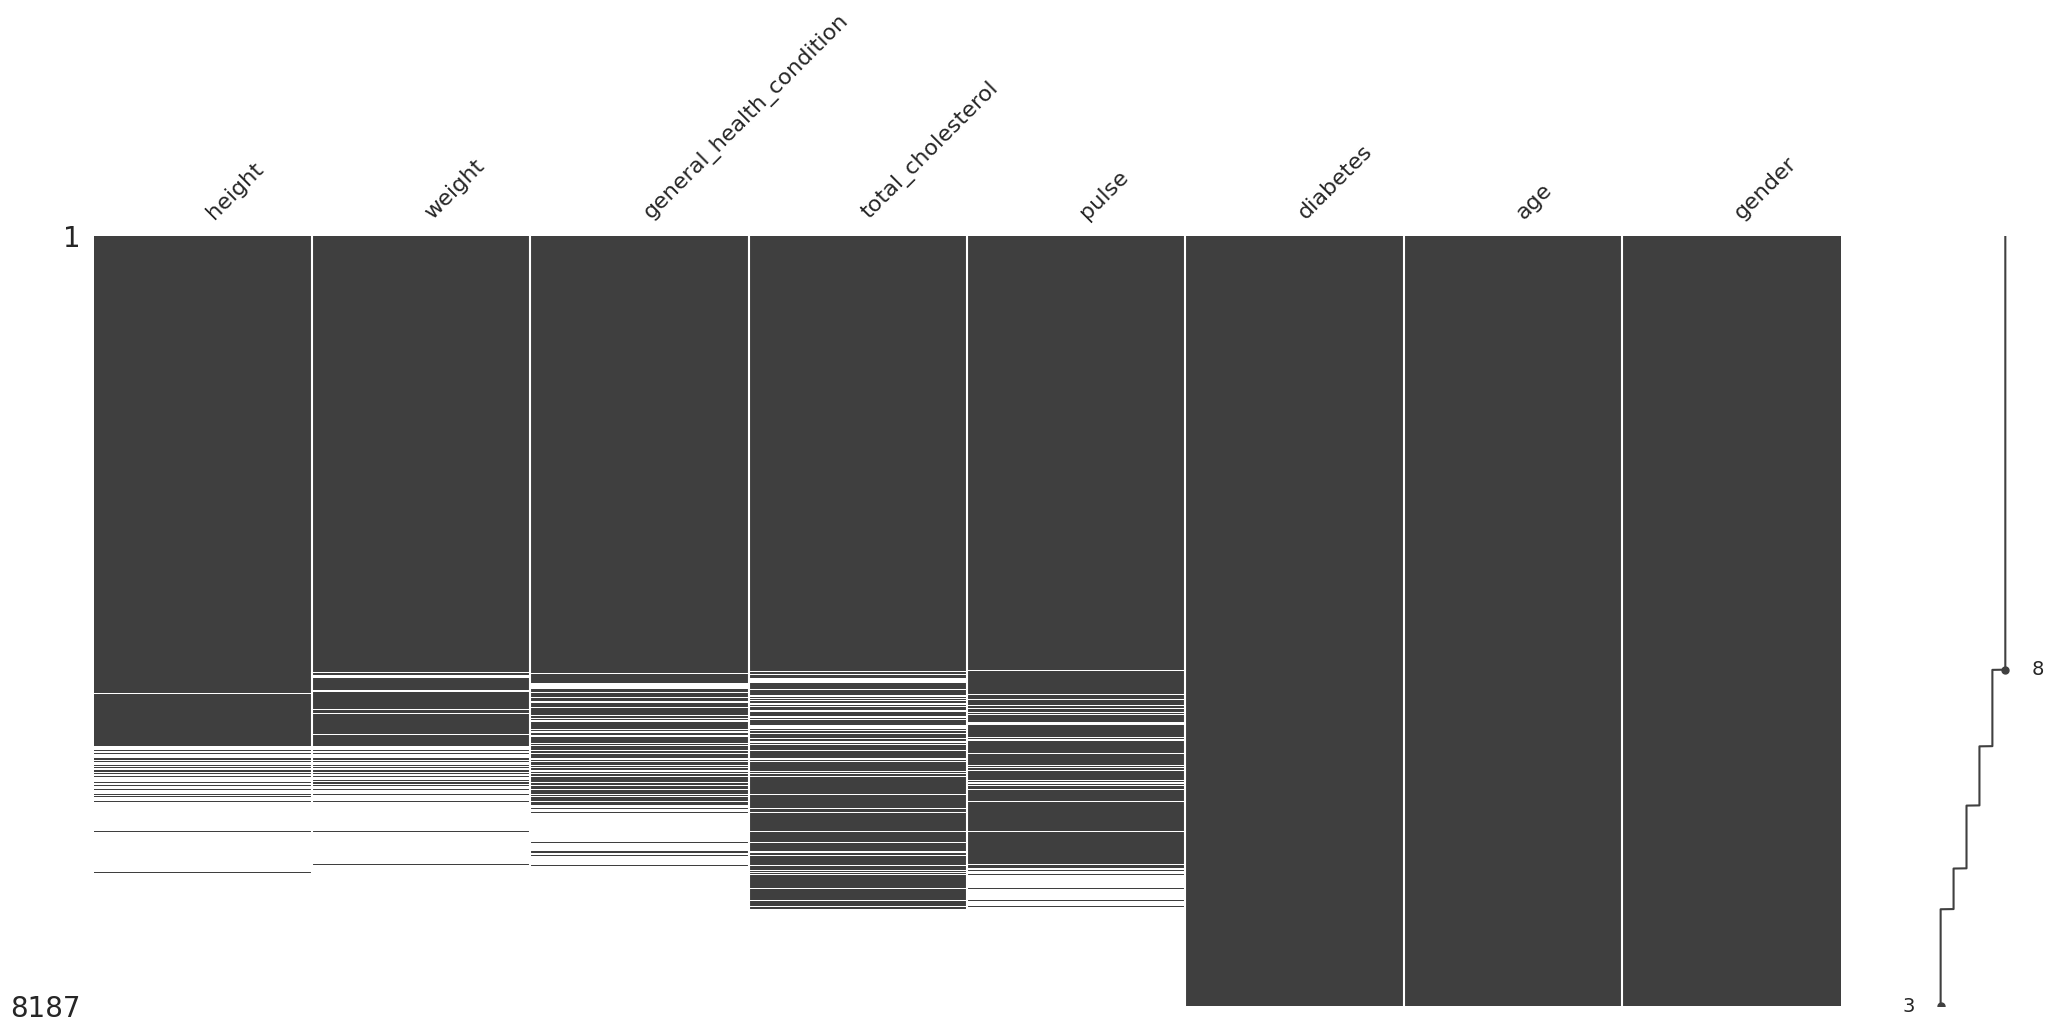

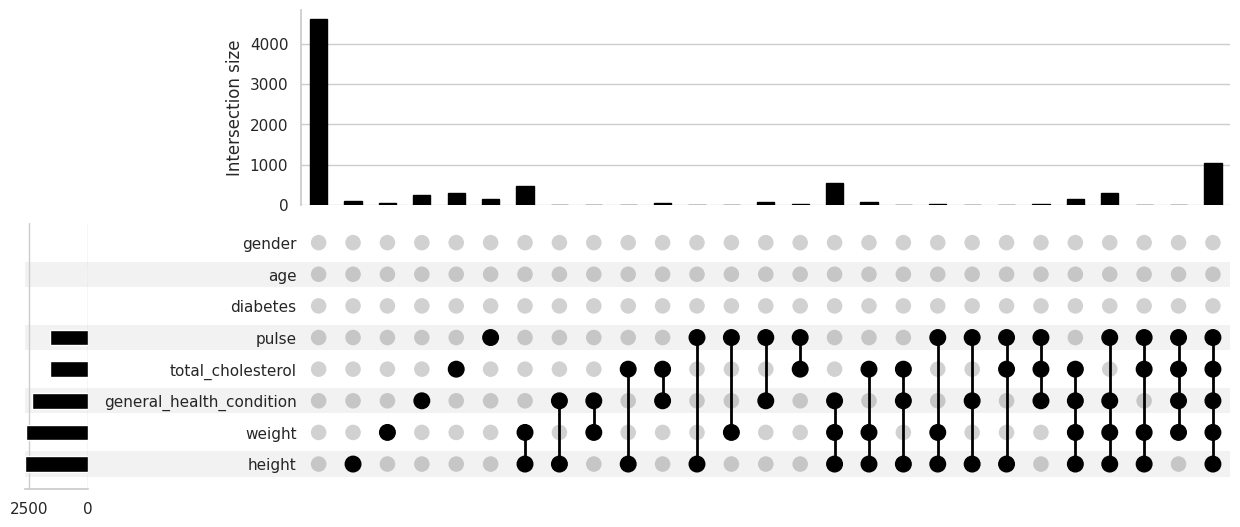

/root/venv/lib/python3.9/site-packages/missingno/missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/root/venv/lib/python3.9/site-packages/missingno/missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


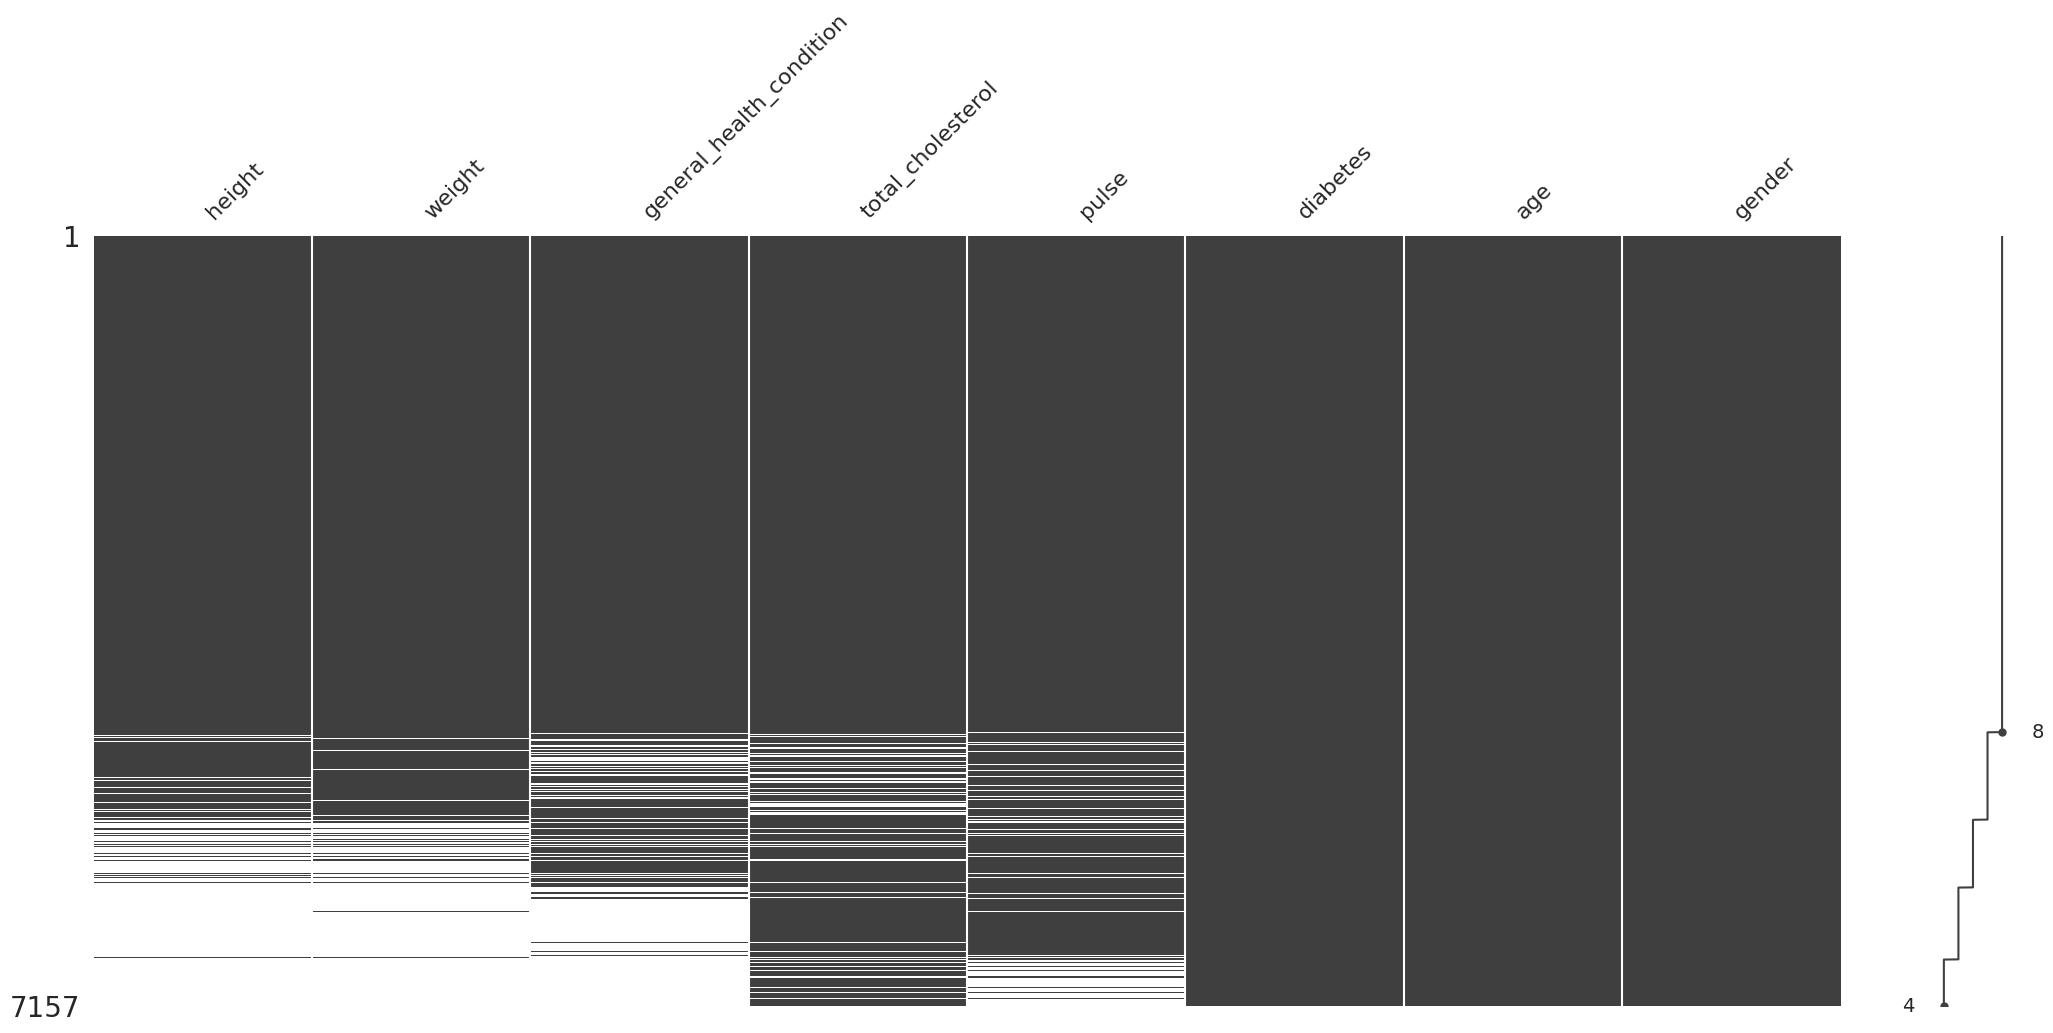

In [8]:
%run download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [9]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

# Ahora se hace una prueba estadistica para determinar si hay o no diferencia en la presencia
# o ausencia de valores de peso

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative="two-sided"
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

Dado que pvalue < 0.05, no se rechaza la hipotesis nula.

No existe diferencia estadistica entre los valores faltantes

Los datos entonces no estan perdidos al azar entre hombres y mujeres

## Tratamiento de variables categóricas para imputación de valores faltantes

In [10]:
# Primero se realiza una copia del dataframe original
nhanes_transformed_df = nhanes_df.copy(deep=True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [11]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [12]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [13]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [14]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [15]:
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns

In [16]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
    #aqui le dices que no modifique las variables que no son categoricas
)

In [17]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0     NaN     NaN              189.0   
93709.0                        NaN     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0     NaN     NaN              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

### _One Hot Encoding_

In [18]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

***pandas.get_dummies()** tiene desventajas comparado con **sklearn.preprocessing.onehotencoder()**, estas son:*

- *No sabe lidiar con valores nulos*
- *Si no se seleccionan todas las columnas, puede que no se detecten todas las categorias* 




In [19]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .pipe(pd.get_dummies)
)

general_health_condition_Excellent  \
SEQN                                           
93705.0                                    0   
93706.0                                    0   
93707.0                                    0   
93709.0                                    0   
93711.0                                    0   
...                                      ...   
102949.0                                   1   
102953.0                                   0   
102954.0                                   0   
102955.0                                   0   
102956.0                                   0   

          general_health_condition_Fair or  general_health_condition_Good  \
SEQN                                                                        
93705.0                                  0                              1   
93706.0                                  0                              0   
93707.0                                  0                              1   
93709.0                                  0                              0   
93711.0                                  0                              0   
...                                    ...                            ...   
102949.0                                 0                              0   
102953.0                                 1                              0   
102954.0                                 0                              1   
102955.0                                 0                              0   
102956.0                                 0                              1   

          general_health_condition_Poor?  general_health_condition_Very good  
SEQN                                                                          
93705.0                                0                                   0  
93706.0                                0                                   1  
93707.0                                0                                   0  
93709.0                                0                                   0  
93711.0                                0                                   1  
...                                  ...                                 ...  
102949.0                               0                                   0  
102953.0                               0                                   0  
102954.0                               0                                   0  
102955.0                               0                                   1  
102956.0                               0                                   0  

[7157 rows x 5 columns]

#### `skelearn.preprocessing.OneHotEncoder()`

*Esta opcion tiene  la ventaja que va a detectar automaticamente todas las categorias*

In [20]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [21]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
)

nhanes_transformed_df2

gender  general_health_condition_Excellent  \
SEQN                                                   
93705.0      0.0                                 0.0   
93706.0      1.0                                 0.0   
93707.0      1.0                                 0.0   
93709.0      0.0                                 0.0   
93711.0      1.0                                 0.0   
...          ...                                 ...   
102949.0     1.0                                 1.0   
102953.0     1.0                                 0.0   
102954.0     0.0                                 0.0   
102955.0     0.0                                 0.0   
102956.0     1.0                                 0.0   

          general_health_condition_Fair or  general_health_condition_Good  \
SEQN                                                                        
93705.0                                0.0                            1.0   
93706.0                                0.0                            0.0   
93707.0                                0.0                            1.0   
93709.0                                0.0                            0.0   
93711.0                                0.0                            0.0   
...                                    ...                            ...   
102949.0                               0.0                            0.0   
102953.0                               1.0                            0.0   
102954.0                               0.0                            1.0   
102955.0                               0.0                            0.0   
102956.0                               0.0                            1.0   

          general_health_condition_Poor?  general_health_condition_Very good  \
SEQN                                                                           
93705.0                              0.0                                 0.0   
93706.0                              0.0                                 1.0   
93707.0                              0.0                                 0.0   
93709.0                              0.0                                 0.0   
93711.0                              0.0                                 1.0   
...                                  ...                                 ...   
102949.0                             0.0                                 0.0   
102953.0                             0.0                                 0.0   
102954.0                             0.0                                 0.0   
102955.0                             0.0                                 1.0   
102956.0                             0.0                                 0.0   

          general_health_condition_nan  height  weight  total_cholesterol  \
SEQN                                                                        
93705.0                            0.0    63.0   165.0              157.0   
93706.0                            0.0    68.0   145.0              148.0   
93707.0                            0.0     NaN     NaN              189.0   
93709.0                            1.0    62.0   200.0              176.0   
93711.0                            0.0    69.0   142.0              238.0   
...                                ...     ...     ...                ...   
102949.0                           0.0    72.0   180.0              201.0   
102953.0                           0.0    65.0   218.0              182.0   
102954.0                           0.0    66.0   150.0              172.0   
102955.0                           0.0     NaN     NaN              150.0   
102956.0                           0.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0 

In [22]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [23]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]]
    )
)

array([['Good']], dtype=object)

# Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

### Media

In [24]:
(
    nhanes_df
    # janitor
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
)

height  weight general_health_condition  total_cholesterol  pulse  \
SEQN                                                                            
93705.0   63.00000   165.0                     Good              157.0   52.0   
93706.0   68.00000   145.0                Very good              148.0   82.0   
93707.0   66.25656     NaN                     Good              189.0  100.0   
93709.0   62.00000   200.0                      NaN              176.0   74.0   
93711.0   69.00000   142.0                Very good              238.0   62.0   
...            ...     ...                      ...                ...    ...   
102949.0  72.00000   180.0                Excellent              201.0   96.0   
102953.0  65.00000   218.0                  Fair or              182.0   78.0   
102954.0  66.00000   150.0                     Good              172.0   78.0   
102955.0  66.25656     NaN                Very good              150.0   74.0   
102956.0  69.00000   250.0                     Good              163.0   76.0   

          diabetes   age  gender  
SEQN                              
93705.0          0  66.0  Female  
93706.0          0  18.0    Male  
93707.0          0  13.0    Male  
93709.0          0  75.0  Female  
93711.0          0  56.0    Male  
...            ...   ...     ...  
102949.0         0  33.0    Male  
102953.0         0  42.0    Male  
102954.0         0  41.0  Female  
102955.0         0  14.0  Female  
102956.0         0  38.0    Male  

[7157 rows x 8 columns]

<AxesSubplot: xlabel='height', ylabel='weight'>

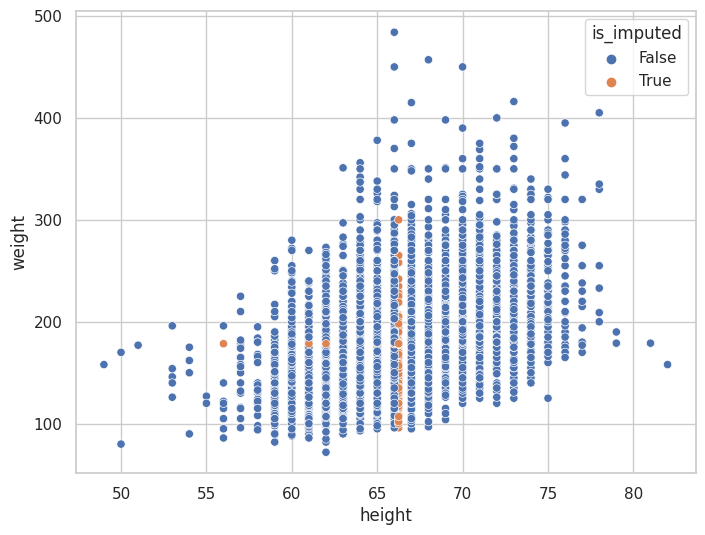

In [25]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True,False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

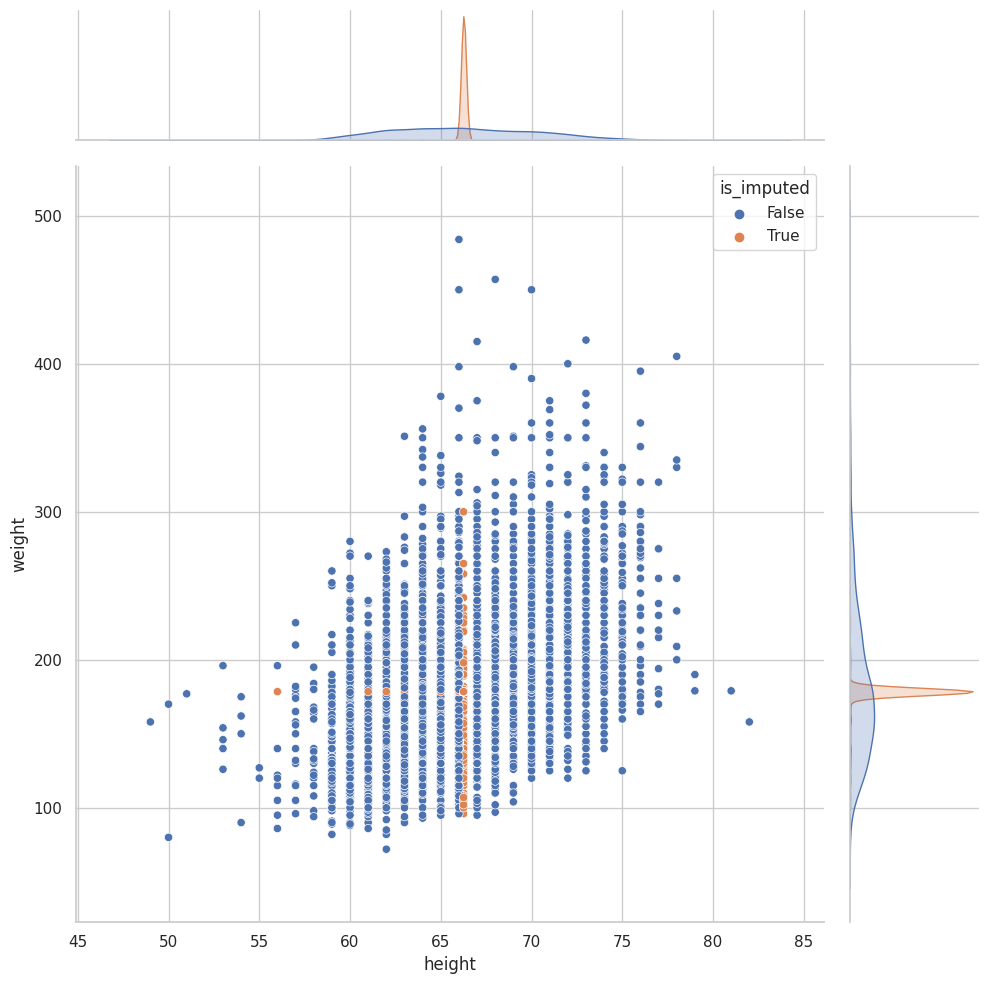

In [26]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True,False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight",
        show_marginal= True,
        height = 10
    )
)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

#### Forwardfill

Imputa el dato de la fila anterior en nuestro missing value

In [27]:
(
    nhanes_df
    .select_columns("height", "weight")
    
    # .fillna(method = "ffill")
    .ffill()
)

height  weight
SEQN                    
93705.0     63.0   165.0
93706.0     68.0   145.0
93707.0     68.0   145.0
93709.0     62.0   200.0
93711.0     69.0   142.0
...          ...     ...
102949.0    72.0   180.0
102953.0    65.0   218.0
102954.0    66.0   150.0
102955.0    66.0   150.0
102956.0    69.0   250.0

[7157 rows x 2 columns]

#### Backfill

Imputa el dato de la fila posterior en nuestro missing value

In [28]:
(
    nhanes_df
    .select_columns("height", "weight")
    
    # .fillna(method = "bfill")
    .bfill()
)

height  weight
SEQN                    
93705.0     63.0   165.0
93706.0     68.0   145.0
93707.0     62.0   200.0
93709.0     62.0   200.0
93711.0     69.0   142.0
...          ...     ...
102949.0    72.0   180.0
102953.0    65.0   218.0
102954.0    66.0   150.0
102955.0    69.0   250.0
102956.0    69.0   250.0

[7157 rows x 2 columns]

#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

*Se recomienda organizar por grupos similares para que no se imputen datos aleatoriamente, sino que el dato que se va a imputar tenga sentido*

In [29]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
)

height  weight  gender  diabetes general_health_condition
SEQN                                                              
94421.0    56.0   115.0  Female         0                Excellent
94187.0    59.0   130.0  Female         0                Excellent
95289.0    59.0   162.0  Female         0                Excellent
97967.0    59.0   130.0  Female         0                Excellent
99125.0    59.0   105.0  Female         0                Excellent
...         ...     ...     ...       ...                      ...
96561.0    74.0   290.0    Male         1                      NaN
96954.0     NaN   175.0    Male         1                      NaN
97267.0     NaN   175.0    Male         1                      NaN
97856.0     NaN   175.0    Male         1                      NaN
98317.0     NaN   175.0    Male         1                      NaN

[7157 rows x 5 columns]

In [30]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
)

/tmp/ipykernel_1384/909901090.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  nhanes_df


height  weight  gender  diabetes general_health_condition
SEQN                                                               
94195.0     63.0    90.0  Female         0                Excellent
95793.0     61.0    96.0  Female         0                Excellent
101420.0    59.0    98.0  Female         0                Excellent
94148.0     65.0   100.0  Female         0                Excellent
102062.0    62.0   100.0  Female         0                Excellent
...          ...     ...     ...       ...                      ...
96561.0     74.0   290.0    Male         1                      NaN
96869.0     72.0   298.0    Male         1                      NaN
97267.0     72.0   298.0    Male         1                      NaN
97856.0     72.0   298.0    Male         1                      NaN
98317.0     72.0   298.0    Male         1                      NaN

[7157 rows x 5 columns]

## Imputación por interpolación

<AxesSubplot: xlabel='date'>

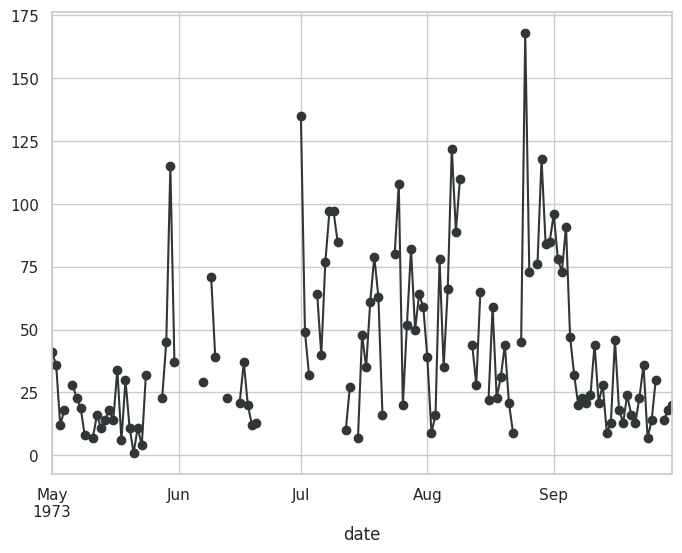

In [31]:
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.plot(color = "#313638", marker= "o")
        )
    )
)

#### Visualizando con ffill

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

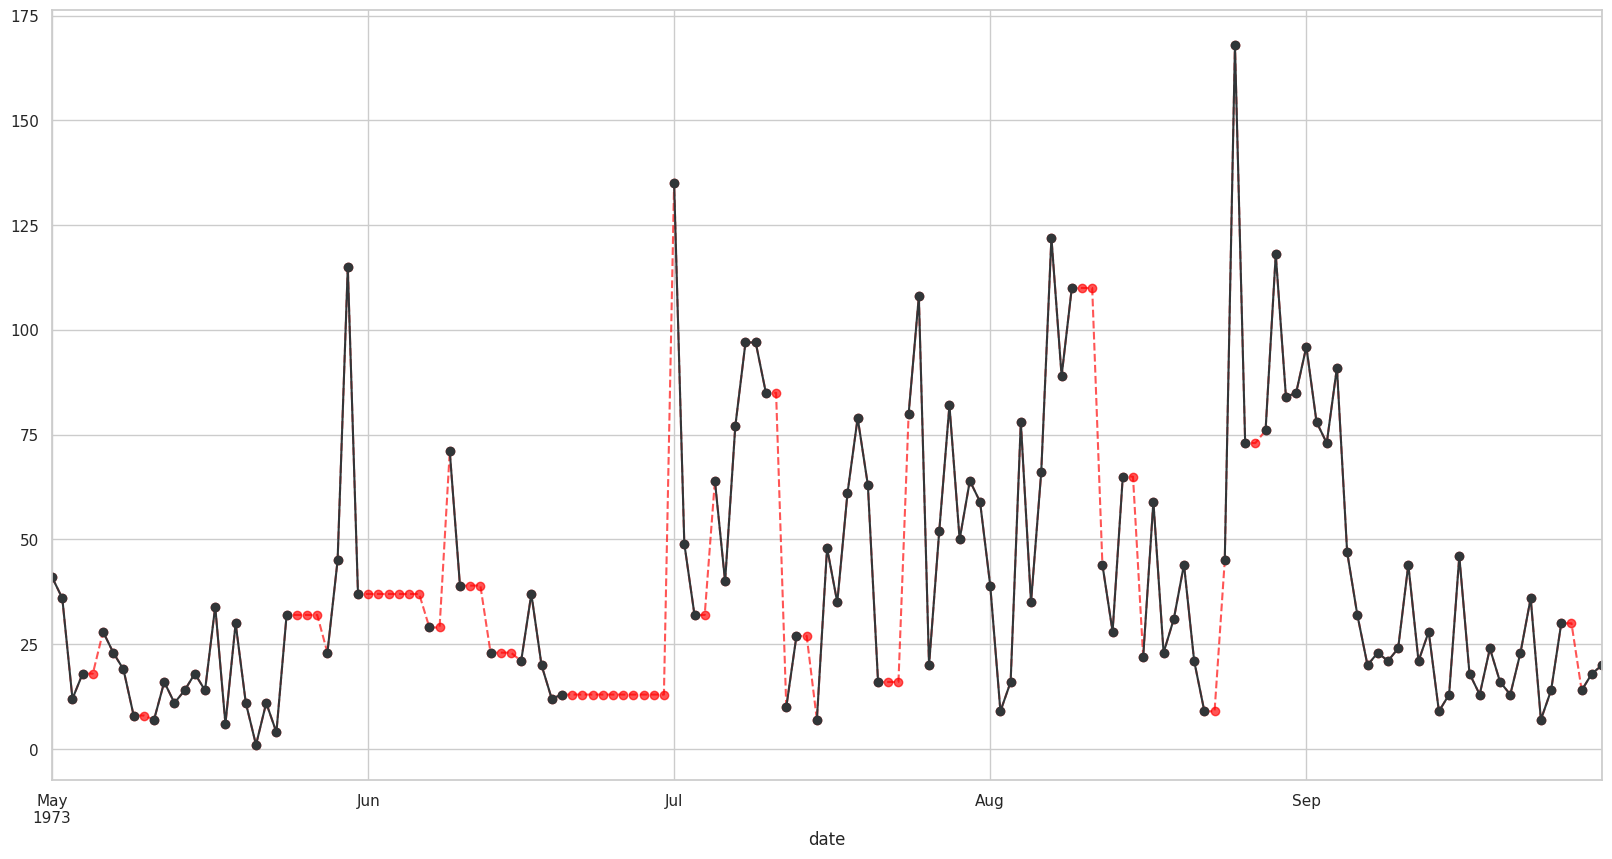

In [32]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color= "red", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.plot(color = "#313638", marker= "o")
        )
    )
)

#### Visualizando con bfill

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

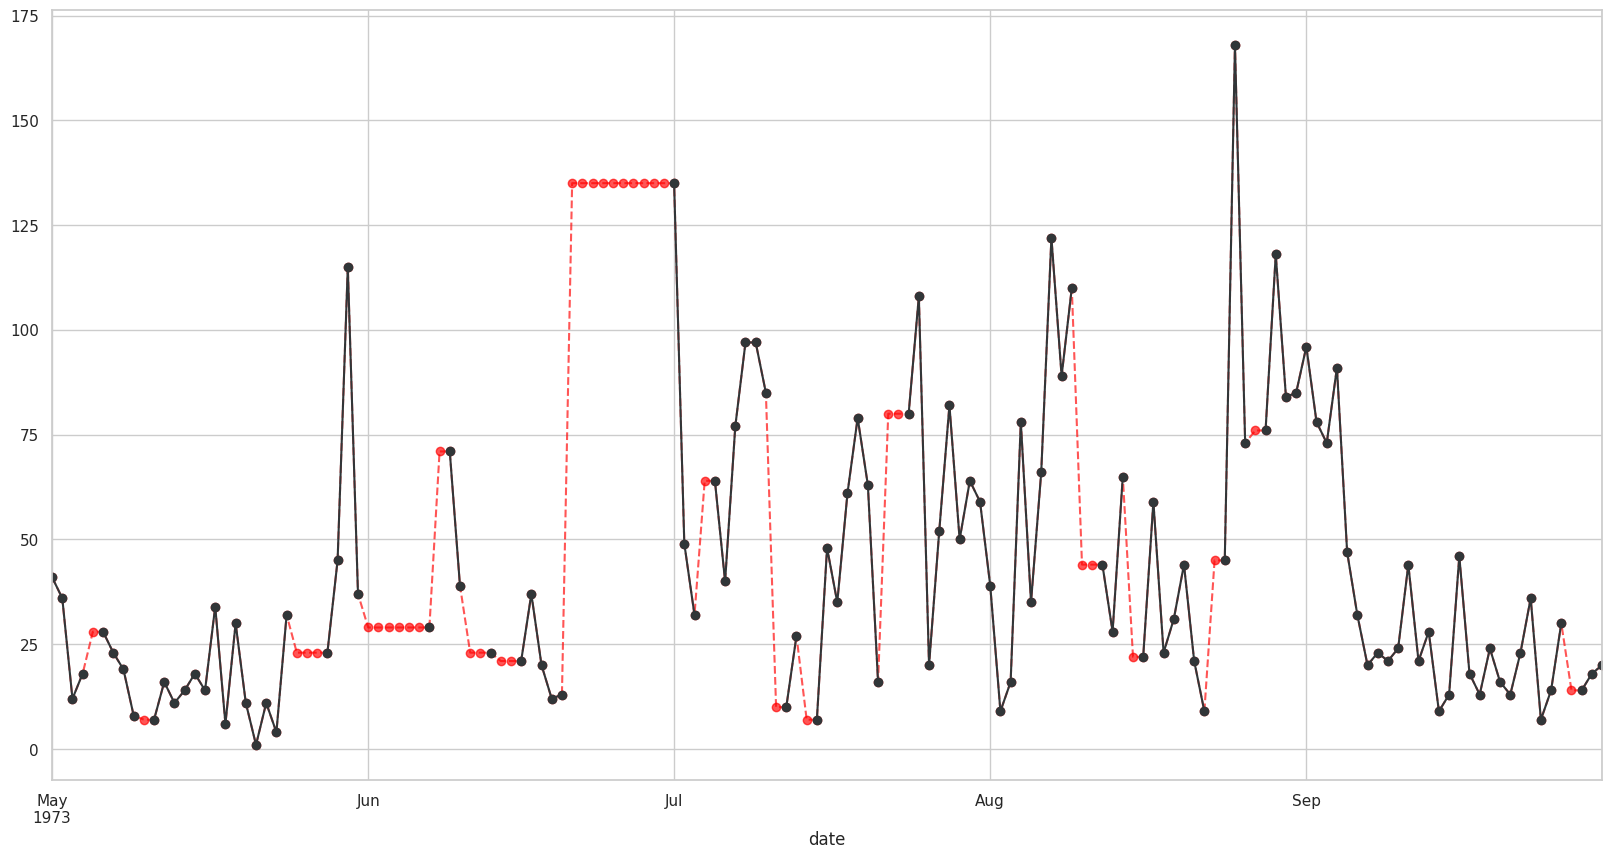

In [33]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color= "red", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.plot(color = "#313638", marker= "o")
        )
    )
)

#### Visualizando con bfill o ffill con valores mas cercanos

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

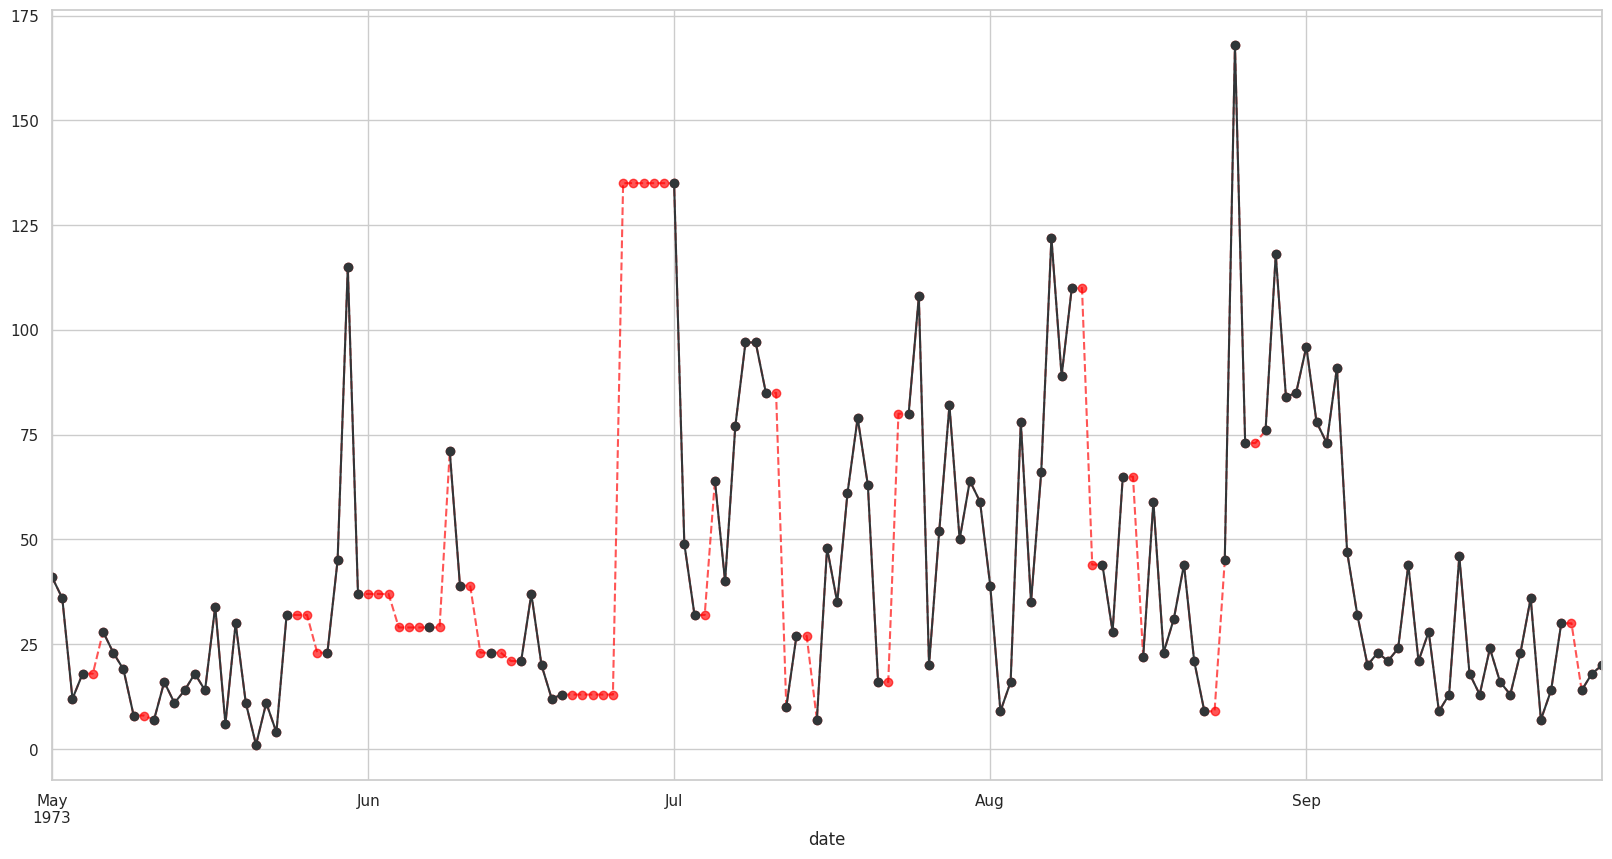

In [34]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "nearest").plot(color= "red", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.plot(color = "#313638", marker= "o")
        )
    )
)

### Visualizando valores interpolados

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

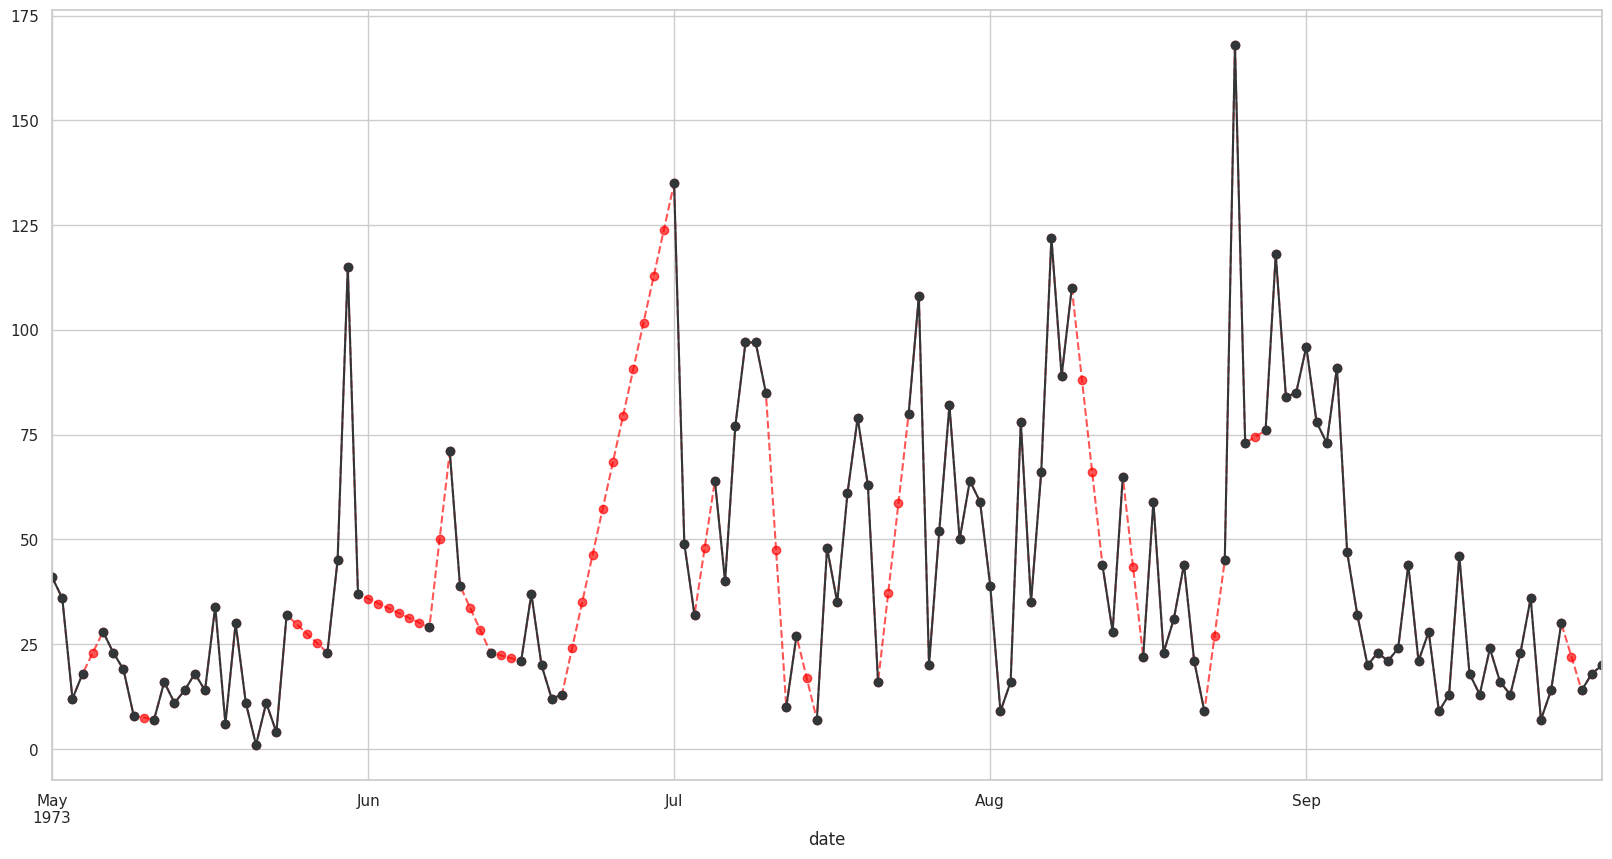

In [35]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "linear").plot(color= "red", marker="o", alpha=6/9, linestyle="dashed"),
            df.ozone.plot(color = "#313638", marker= "o")
        )
    )
)

*Ahora para asignar esos valores a la columna:*

In [36]:
airquality_df["ozone"] = airquality_df.ozone.interpolate(method="linear")

In [37]:
airquality_df

ozone  solar_r  wind  temp  month  day  year
date                                                    
1973-05-01   41.0    190.0   7.4    67      5    1  1973
1973-05-02   36.0    118.0   8.0    72      5    2  1973
1973-05-03   12.0    149.0  12.6    74      5    3  1973
1973-05-04   18.0    313.0  11.5    62      5    4  1973
1973-05-05   23.0      NaN  14.3    56      5    5  1973
...           ...      ...   ...   ...    ...  ...   ...
1973-09-26   30.0    193.0   6.9    70      9   26  1973
1973-09-27   22.0    145.0  13.2    77      9   27  1973
1973-09-28   14.0    191.0  14.3    75      9   28  1973
1973-09-29   18.0    131.0   8.0    76      9   29  1973
1973-09-30   20.0    223.0  11.5    68      9   30  1973

[153 rows x 7 columns]

## Imputación por algoritmo de vecinos más cercanos (KNN)

*K nearest neighbors (KNN) es el algritmo mas utilizado de imputacion*

*Resumen de métodos de distancia:*

- *Euclidiana: Útil para variables numéricas*
- *Manhattan: Útil paa variables tipo factor*
- *Hamming: Útil para variables categóricas*
- *Gower: Útil para conjuntos de datos con variables mixtas*

In [38]:
nhanes_transformed_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0     NaN     NaN              189.0   
93709.0                        NaN     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0     NaN     NaN              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

#### KNN algorithm

In [39]:
knn_imputer = sklearn.impute.KNNImputer()

#copia del df original
nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df).round()
nhanes_df_knn

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0    69.0   130.0              189.0   
93709.0                        2.0     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0    71.0   159.0              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

In [40]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
)

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0    69.0   130.0              189.0   
93709.0                        2.0     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0    71.0   159.0              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  height_imp  weight_imp  \
SEQN                                                      
93705.0    52.0       0.0  66.0       False       False   
93706.0    82.0       0.0  18.0       False       False   
93707.0   100.0       0.0  13.0        True        True   
93709.0    74.0       0.0  75.0       False       False   
93711.0    62.0       0.0  56.0       False       False   
...         ...       ...   ...         ...         ...   
102949.0   96.0       0.0  33.0       False       False   
102953.0   78.0       0.0  42.0       False       False   
102954.0   78.0       0.0  41.0       False       False   
102955.0   74.0       0.0  14.0        True        True   
102956.0   76.0       0.0  38.0       False       False   

          general_health_condition_imp  total_cholesterol_imp  pulse_imp  
SEQN                                                                      
93705.0                          False                  False      False  
93706.0                          False                  False      False  
93707.0                          False                  False      False  
93709.0                           True                  False      False  
93711.0                          False                  False      False  
...                                ...                    ...        ...  
102949.0                         False                  False      False  
102953.0                         False                  False      False  
102954.0                         False                  False      False  
102955.0                         False                  False      False  
102956.0                         False                  False      False  

[7157 rows x 13 columns]

<AxesSubplot: xlabel='height', ylabel='weight'>

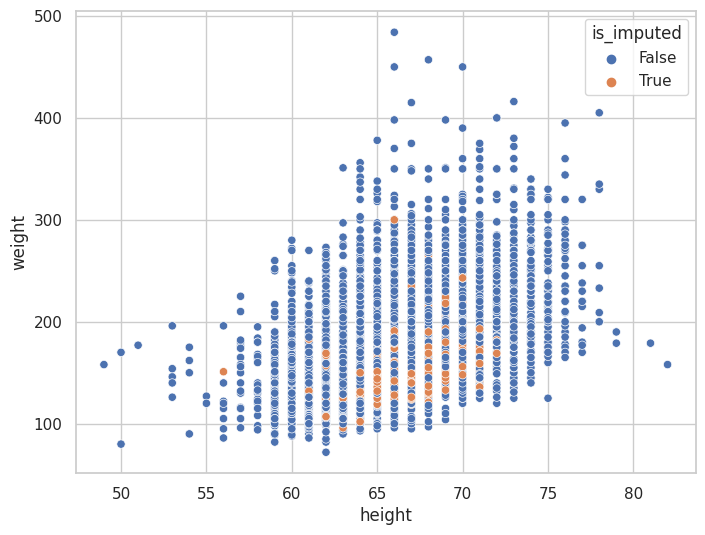

In [41]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

### Ordenamiento por cantidad de variables faltantes

In [42]:
knn_imputer = sklearn.impute.KNNImputer()

#copia del df original
nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True)).round()
nhanes_df_knn

gender  diabetes   age  pulse  total_cholesterol  \
SEQN                                                         
93705.0      0.0       0.0  66.0   52.0              157.0   
93706.0      1.0       0.0  18.0   82.0              148.0   
93707.0      1.0       0.0  13.0  100.0              189.0   
93709.0      0.0       0.0  75.0   74.0              176.0   
93711.0      1.0       0.0  56.0   62.0              238.0   
...          ...       ...   ...    ...                ...   
102949.0     1.0       0.0  33.0   96.0              201.0   
102953.0     1.0       0.0  42.0   78.0              182.0   
102954.0     0.0       0.0  41.0   78.0              172.0   
102955.0     0.0       0.0  14.0   74.0              150.0   
102956.0     1.0       0.0  38.0   76.0              163.0   

          general_health_condition  weight  height  
SEQN                                                
93705.0                        2.0   165.0    63.0  
93706.0                        4.0   145.0    68.0  
93707.0                        2.0   130.0    69.0  
93709.0                        2.0   200.0    62.0  
93711.0                        4.0   142.0    69.0  
...                            ...     ...     ...  
102949.0                       0.0   180.0    72.0  
102953.0                       1.0   218.0    65.0  
102954.0                       2.0   150.0    66.0  
102955.0                       4.0   159.0    71.0  
102956.0                       2.0   250.0    69.0  

[7157 rows x 8 columns]

<AxesSubplot: xlabel='height', ylabel='weight'>

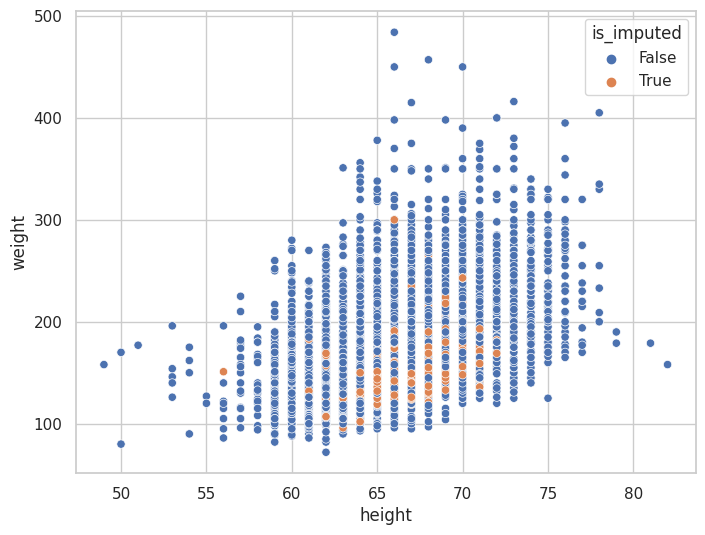

In [43]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

## Imputación basada en modelos

In [44]:
nhanes_model_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "age")
    .sort_values("weight")
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix="_imp",
        only_missing = False
    )
)

nhanes_model_df

height  weight  gender   age  height_imp  weight_imp  gender_imp  \
SEQN                                                                         
99970.0     62.0    72.0    Male  16.0       False       False       False   
97877.0     50.0    80.0  Female  29.0       False       False       False   
96451.0     59.0    82.0  Female  80.0       False       False       False   
97730.0     62.0    82.0  Female  19.0       False       False       False   
99828.0     62.0    85.0  Female  16.0       False       False       False   
...          ...     ...     ...   ...         ...         ...         ...   
102915.0     NaN   484.0  Female  14.0        True       False       False   
102926.0     NaN   484.0  Female  15.0        True       False       False   
102941.0     NaN   484.0  Female  14.0        True       False       False   
102945.0     NaN   484.0    Male  15.0        True       False       False   
102955.0     NaN   484.0  Female  14.0        True       False       False   

          age_imp  
SEQN               
99970.0     False  
97877.0     False  
96451.0     False  
97730.0     False  
99828.0     False  
...           ...  
102915.0    False  
102926.0    False  
102941.0    False  
102945.0    False  
102955.0    False  

[7157 rows x 8 columns]

In [45]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols("height ~ weight + age", data=df)
    )
    .fit()
)

In [46]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
100246.0    64.0
101209.0    64.0
102766.0    64.0
102509.0    64.0
96900.0     65.0
            ... 
102915.0    75.0
102926.0    75.0
102941.0    75.0
102945.0    75.0
102955.0    75.0
Length: 1669, dtype: float64

In [47]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values
nhanes_model_df

height  weight  gender   age  height_imp  weight_imp  gender_imp  \
SEQN                                                                         
99970.0     62.0    72.0    Male  16.0       False       False       False   
97877.0     50.0    80.0  Female  29.0       False       False       False   
96451.0     59.0    82.0  Female  80.0       False       False       False   
97730.0     62.0    82.0  Female  19.0       False       False       False   
99828.0     62.0    85.0  Female  16.0       False       False       False   
...          ...     ...     ...   ...         ...         ...         ...   
102915.0    75.0   484.0  Female  14.0        True       False       False   
102926.0    75.0   484.0  Female  15.0        True       False       False   
102941.0    75.0   484.0  Female  14.0        True       False       False   
102945.0    75.0   484.0    Male  15.0        True       False       False   
102955.0    75.0   484.0  Female  14.0        True       False       False   

          age_imp  
SEQN               
99970.0     False  
97877.0     False  
96451.0     False  
97730.0     False  
99828.0     False  
...           ...  
102915.0    False  
102926.0    False  
102941.0    False  
102945.0    False  
102955.0    False  

[7157 rows x 8 columns]

<AxesSubplot: xlabel='weight', ylabel='height'>

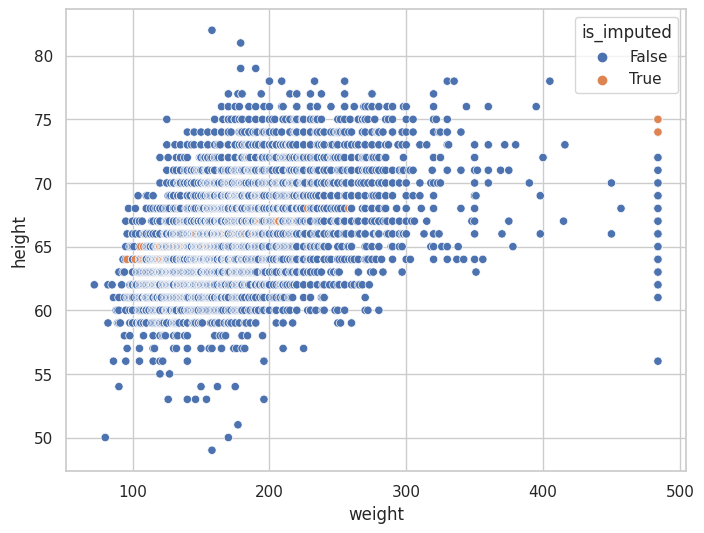

In [48]:
(
    nhanes_model_df
    .missing.scatter_imputation_plot(
        x = "weight",
        y = "height"
    )
)

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

In [49]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),
    initial_strategy="mean",
    imputation_order="ascending"
)

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)

nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp")
    ],    
    axis=1
)

nhanes_mice_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0    70.0   200.0              189.0   
93709.0                        2.0     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0    64.0   159.0              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  height_imp  weight_imp  \
SEQN                                                      
93705.0    52.0       0.0  66.0       False       False   
93706.0    82.0       0.0  18.0       False       False   
93707.0   100.0       0.0  13.0        True        True   
93709.0    74.0       0.0  75.0       False       False   
93711.0    62.0       0.0  56.0       False       False   
...         ...       ...   ...         ...         ...   
102949.0   96.0       0.0  33.0       False       False   
102953.0   78.0       0.0  42.0       False       False   
102954.0   78.0       0.0  41.0       False       False   
102955.0   74.0       0.0  14.0        True        True   
102956.0   76.0       0.0  38.0       False       False   

          general_health_condition_imp  total_cholesterol_imp  pulse_imp  \
SEQN                                                                       
93705.0                          False                  False      False   
93706.0                          False                  False      False   
93707.0                          False                  False      False   
93709.0                           True                  False      False   
93711.0                          False                  False      False   
...                                ...                    ...        ...   
102949.0                         False                  False      False   
102953.0                         False                  False      False   
102954.0                         False                  False      False   
102955.0                         False                  False      False   
102956.0                         False                  False      False   

          diabetes_imp  age_imp  gender_imp  
SEQN                                         
93705.0          False    False       False  
93706.0          False    False       False  
93707.0          False    False       False  
93709.0          False    False       False  
93711.0          False    False       False  
...                ...      ...         ...  
102949.0         False    False       False  
102953.0         False    False       False  
102954.0         False    False       False  
102955.0         False    False       False  
102956.0         False    False       False  

[7157 rows x 16 columns]

<AxesSubplot: xlabel='height', ylabel='weight'>

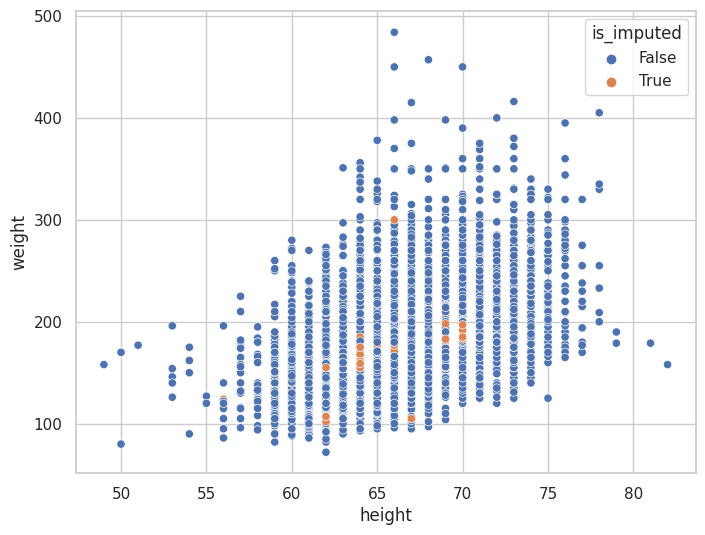

In [50]:
nhanes_mice_df.missing.scatter_imputation_plot(
    x = "height",
    y = "weight"
)

## Transformación inversa de los datos

*Deshacer la transformacion en dummy*

In [51]:
nhanes_imputed_df = nhanes_mice_df.copy(deep=True)

In [52]:
nhanes_imputed_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)

nhanes_imputed_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                           
93705.0                      Good  Female    63.0   165.0              157.0   
93706.0                 Very good    Male    68.0   145.0              148.0   
93707.0                      Good    Male    70.0   200.0              189.0   
93709.0                      Good  Female    62.0   200.0              176.0   
93711.0                 Very good    Male    69.0   142.0              238.0   
...                           ...     ...     ...     ...                ...   
102949.0                Excellent    Male    72.0   180.0              201.0   
102953.0                  Fair or    Male    65.0   218.0              182.0   
102954.0                     Good  Female    66.0   150.0              172.0   
102955.0                Very good  Female    64.0   159.0              150.0   
102956.0                     Good    Male    69.0   250.0              163.0   

          pulse  diabetes   age  height_imp  weight_imp  \
SEQN                                                      
93705.0    52.0       0.0  66.0       False       False   
93706.0    82.0       0.0  18.0       False       False   
93707.0   100.0       0.0  13.0        True        True   
93709.0    74.0       0.0  75.0       False       False   
93711.0    62.0       0.0  56.0       False       False   
...         ...       ...   ...         ...         ...   
102949.0   96.0       0.0  33.0       False       False   
102953.0   78.0       0.0  42.0       False       False   
102954.0   78.0       0.0  41.0       False       False   
102955.0   74.0       0.0  14.0        True        True   
102956.0   76.0       0.0  38.0       False       False   

          general_health_condition_imp  total_cholesterol_imp  pulse_imp  \
SEQN                                                                       
93705.0                          False                  False      False   
93706.0                          False                  False      False   
93707.0                          False                  False      False   
93709.0                           True                  False      False   
93711.0                          False                  False      False   
...                                ...                    ...        ...   
102949.0                         False                  False      False   
102953.0                         False                  False      False   
102954.0                         False                  False      False   
102955.0                         False                  False      False   
102956.0                         False                  False      False   

          diabetes_imp  age_imp  gender_imp  
SEQN                                         
93705.0          False    False       False  
93706.0          False    False       False  
93707.0          False    False       False  
93709.0          False    False       False  
93711.0          False    False       False  
...                ...      ...         ...  
102949.0         False    False       False  
102953.0         False    False       False  
102954.0         False    False       False  
102955.0         False    False       False  
102956.0         False    False       False  

[7157 rows x 16 columns]

*Comparativa de valores antes de imputacion con valores despues de imputacion*

In [53]:
nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [54]:
nhanes_imputed_df.general_health_condition.value_counts()

Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

*Me quedan entonces valores faltantes?*

In [56]:
nhanes_imputed_df.missing.number_missing()

0

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b1c0ea21-568f-4a51-b8a9-f64bf5f251a7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>